# Face Clustering

Face clustering uses an **unsupervised learning** approach as we have face images with no names or labels. We need to identify and count the number of unique people in an image dataset.

The idea of **Density-Based Spatial Clustering of Applications with Noise** (DBSCAN) is that if a particular point belongs to a cluster, it should be near to lots of other points in that cluster.

First choose a positive number `epsilon` and a natural number `min-Points`. Then begin picking an arbitrary point in the dataset. If there are more than `minPoints` points within a distance of `epsilon` from that point, including the original point itself, consider all of them to be part of a cluster. Then expand that cluster by checking all of the new points and see if they also have more than `minPoints` points within a distance of `epsilon`, growing the cluster recursively if so.

In [1]:
from imutils import paths
from imutils import build_montages
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import face_recognition
import pickle
import cv2
import os
from tqdm.notebook import tqdm

First, test `face_recognition` library:

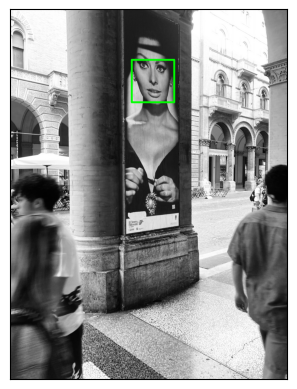

In [2]:
image = cv2.imread('./test/img_6292.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
rects = face_recognition.face_locations(image, model='hog')  # either `hog` or `cnn`

def printImage(image, rects):
    for (top, right, bottom, left) in rects:
        image = cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 20)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()

printImage(image, rects);

Store face encodings of all images in `test` folder:

In [3]:
imagePaths = list(paths.list_images('./test'))

data = []
for imagePath in tqdm(imagePaths):
#for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    _rects = face_recognition.face_locations(image, model='hog')  # either `hog` or `cnn`
    rects = []
    for (top, right, bottom, left) in _rects:
        area = (bottom - top) * (right - left)
        if area > 30000:
            rects.append((top, right, bottom, left))
    if len(rects) > 0:
        # printImage(image, rects)
        encodings = face_recognition.face_encodings(image, rects)
        d = [{'imagePath': imagePath, 'loc': rect, 'encoding': enc} for (rect, enc) in zip(rects, encodings)]
        data.extend(d)
    
print('serializing encodings...')
f = open('face_encodings.pickle', 'wb')
f.write(pickle.dumps(data))
f.close()

  0%|          | 0/1 [00:00<?, ?it/s]

serializing encodings...


In [4]:
data = pickle.loads(open('./face_encodings.pickle', 'rb').read())
data = np.array(data)
encodings = [d['encoding'] for d in data]

clt = DBSCAN(metric='euclidean', eps=0.5, min_samples=10)
clt.fit(encodings)

labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print(f'number of unique faces: {numUniqueFaces + 1}')

number of unique faces: 1


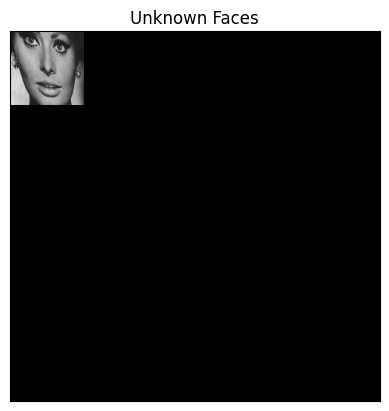

In [5]:
for labelID in labelIDs:
    idxs = np.where(clt.labels_ == labelID)[0]
    idxs = np.random.choice(idxs, size=min(25, len(idxs)), replace=False)

    faces = []
    for i in idxs:
        image = cv2.imread(data[i]['imagePath'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        (top, right, bottom, left) = data[i]['loc']
        face = image[top:bottom, left:right]
        face = cv2.resize(face, (96, 96))
        faces.append(face)
        
    montage = build_montages(faces, (96, 96), (5, 5))[0]
    title = f'Face ID #{labelID}'
    title = 'Unknown Faces' if labelID == -1 else title
    plt.imshow(montage)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show();